# Creating and testing RSI Strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("eurusd.csv", parse_dates = ["Date"], index_col = "Date")

In [3]:
data

,price
Date,
2004-01-01,1.258194
2004-01-02,1.258194
2004-01-05,1.268698
2004-01-06,1.272103
2004-01-07,1.264095
...,...
2020-06-24,1.131235
2020-06-25,1.125087
2020-06-26,1.122208


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4275 entries, 2004-01-01 to 2020-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4275 non-null   float64
dtypes: float64(1)
memory usage: 66.8 KB


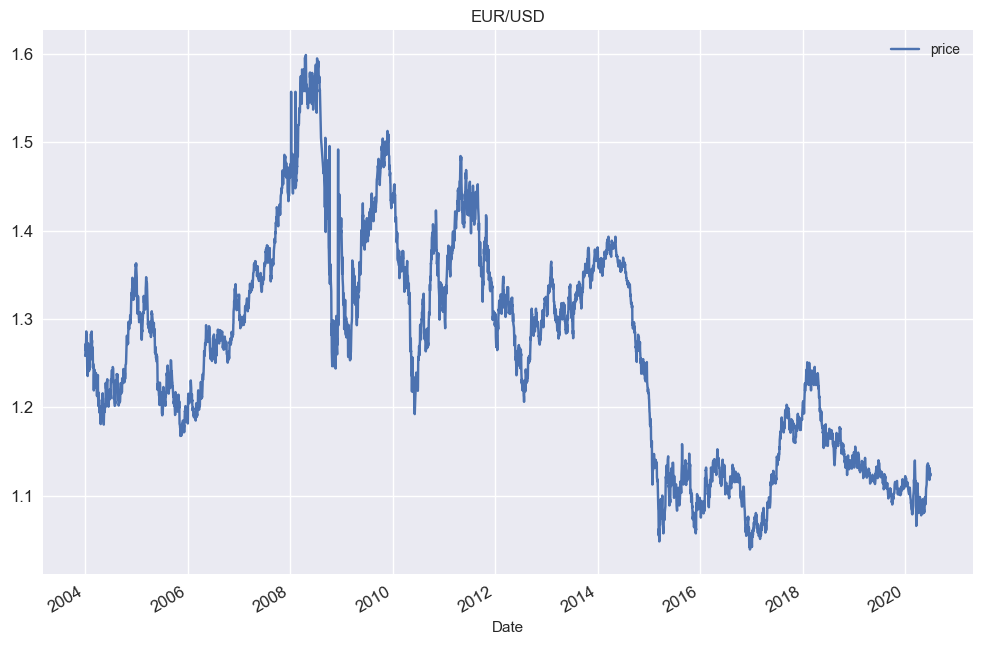

In [5]:
data.plot(figsize = (12, 8), title = "EUR/USD", fontsize = 12)
plt.show()

## Defining an RSI Strategy

In [6]:
data.price.diff()

Date
2004-01-01         NaN
2004-01-02    0.000000
2004-01-05    0.010504
2004-01-06    0.003405
2004-01-07   -0.008008
                ...   
2020-06-24    0.003267
2020-06-25   -0.006147
2020-06-26   -0.002879
2020-06-29    0.000378
2020-06-30    0.002134
Name: price, Length: 4275, dtype: float64

__U:__ <br>
- if __positive__ price change ("up"): __price change__<br>
- if __negative__ price change ("down"): __0__

In [7]:
data["U"] = np.where(data.price.diff() > 0, data.price.diff(), 0)

__D:__ <br>
- if __positive__ price change ("up"): __0__<br>
- if __negative__ price change ("down"): __-price change__

In [8]:
data["D"] = np.where(data.price.diff() < 0, -data.price.diff(), 0)

In [9]:
data

,price,U,D
Date,,,
2004-01-01,1.258194,0.000000,0.000000
2004-01-02,1.258194,0.000000,0.000000
2004-01-05,1.268698,0.010504,0.000000
2004-01-06,1.272103,0.003405,0.000000
2004-01-07,1.264095,0.000000,0.008008
...,...,...,...
2020-06-24,1.131235,0.003267,0.000000
2020-06-25,1.125087,0.000000,0.006147
2020-06-26,1.122208,0.000000,0.002879


__Calculate Moving Averages for U and D__ (alternative: exponential smoothing)

In [10]:
periods = 20

In [11]:
data["MA_U"] = data.U.rolling(periods).mean()

In [12]:
data["MA_D"] = data.D.rolling(periods).mean()

In [13]:
data

,price,U,D,MA_U,MA_D
Date,,,,,
2004-01-01,1.258194,0.000000,0.000000,NaN,NaN
2004-01-02,1.258194,0.000000,0.000000,NaN,NaN
2004-01-05,1.268698,0.010504,0.000000,NaN,NaN
2004-01-06,1.272103,0.003405,0.000000,NaN,NaN
2004-01-07,1.264095,0.000000,0.008008,NaN,NaN
...,...,...,...,...,...
2020-06-24,1.131235,0.003267,0.000000,0.003182,0.001530
2020-06-25,1.125087,0.000000,0.006147,0.003007,0.001837
2020-06-26,1.122208,0.000000,0.002879,0.002696,0.001981


__Calculate Relative Strength Index (RSI)__

In [14]:
data["RSI"] = data.MA_U / (data.MA_U + data.MA_D) * 100

In [15]:
data.dropna(inplace = True)

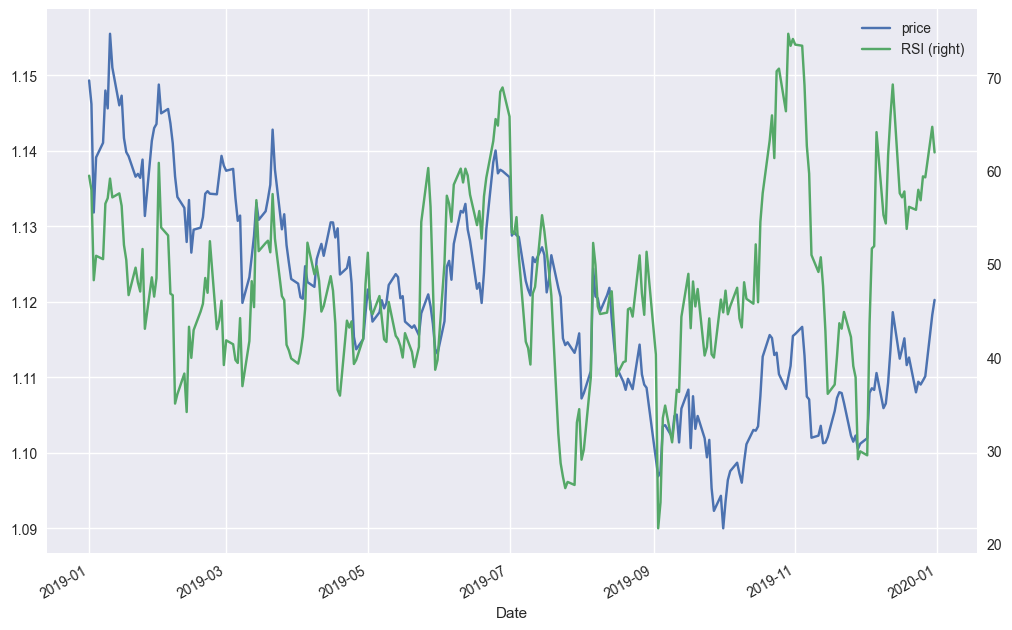

In [16]:
data.loc["2019", ["price", "RSI"]].plot(figsize = (12, 8), secondary_y = "RSI")
plt.show()

Instruments which have had
- __more or stronger positive changes__ have a __higher RSI__
- __more or stronger negative changes__ have a __lower RSI__

- Extreme __high RSI__ (>70) indicates __overbought__ instrument -> __sell__
- Extreme __low RSI__ (<30) indicates __oversold__ instrument -> __buy__ 

In [17]:
rsi_upper = 70
rsi_lower = 30

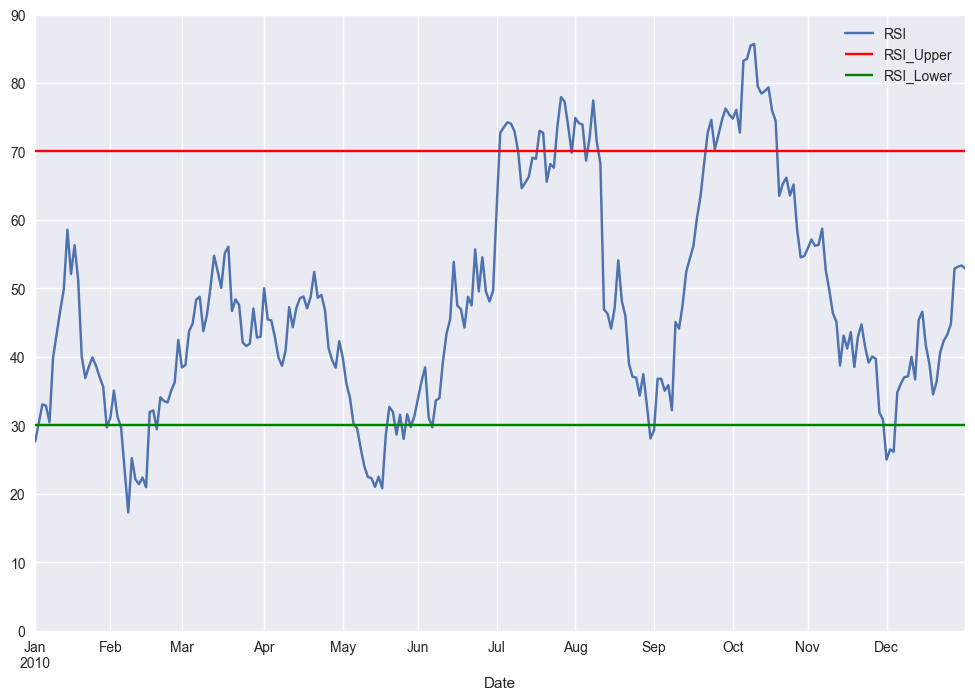

In [18]:
data.loc["2010", ["RSI"]].plot(figsize = (12, 8))
plt.hlines(y = rsi_upper, xmin = data.index[0], xmax = data.index[-1], label = "RSI_Upper", color = "r")
plt.hlines(y = rsi_lower, xmin = data.index[0], xmax = data.index[-1], label = "RSI_Lower", color = "g")
plt.yticks(ticks = range(0, 100, 10))
plt.legend()
plt.show()

In [19]:
data["position"] = np.where(data.RSI > rsi_upper, -1, np.nan) # 1. overbought -> go short

In [20]:
data["position"] = np.where(data.RSI < rsi_lower, 1, data.position) # 2. oversold -> go long

In [21]:
data.position = data.position.fillna(0) # 3. where 1 & 2 isn´t applicable -> neutral

In [22]:
data.position.value_counts()

position
 0.0    3637
-1.0     316
 1.0     303
Name: count, dtype: int64

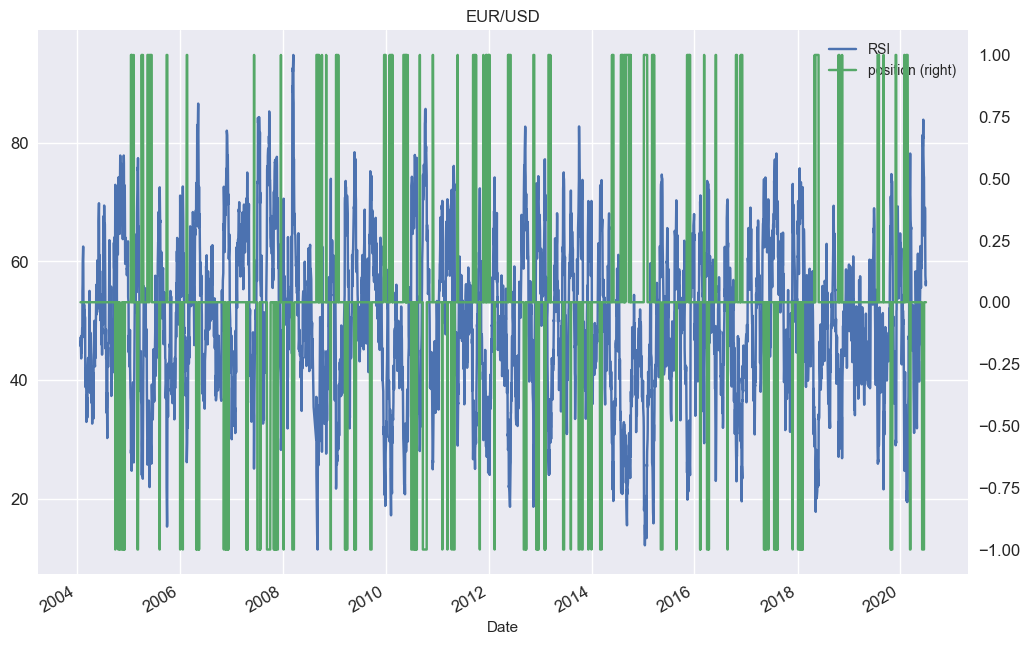

In [23]:
data.loc[:, ["RSI", "position"]].plot(figsize = (12, 8), fontsize = 12, 
                                                      secondary_y = "position", title = "EUR/USD")
plt.show()

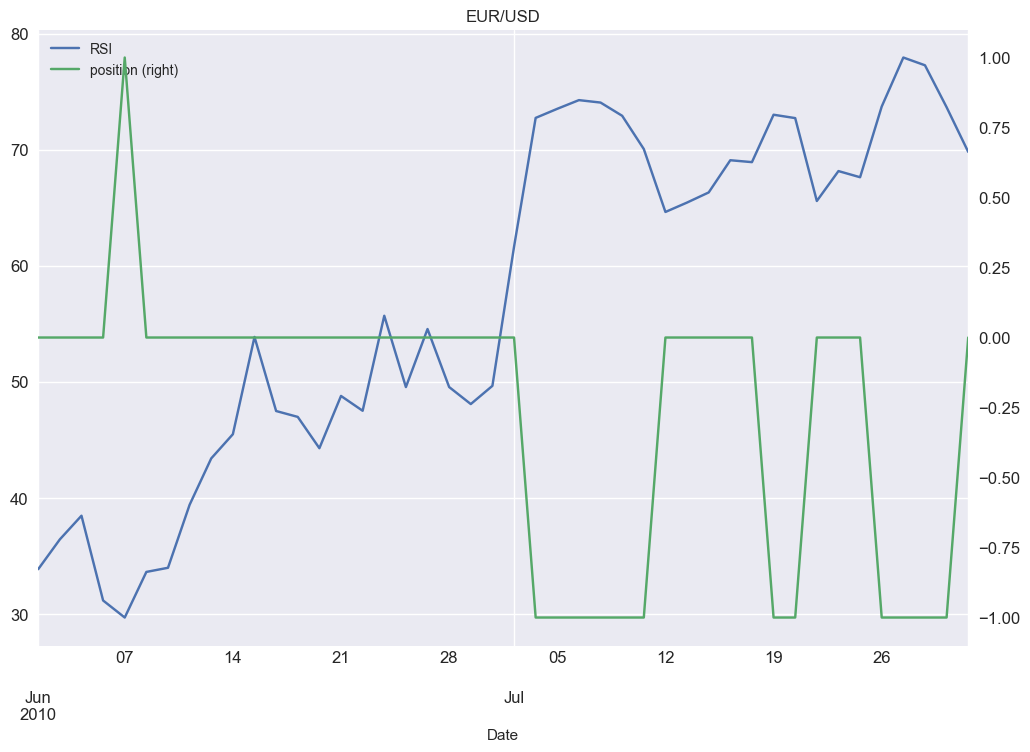

In [24]:
data.loc["06-2010":"07-2010", ["RSI", "position"]].plot(figsize = (12, 8), fontsize = 12, 
                                                      secondary_y = "position", title = "EUR/USD")
plt.show()

## Vectorized Strategy Backtesting

In [25]:
data["returns"] = np.log(data.price.div(data.price.shift(1)))

In [26]:
data.dropna(inplace = True)

In [27]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [28]:
data.dropna(inplace = True)

In [29]:
ptc = 0.00007

In [30]:
data["trades"] = data.position.diff().fillna(0).abs()

In [31]:
data.trades.value_counts()

trades
0.0    3926
1.0     328
Name: count, dtype: int64

In [32]:
data["strategy_net"] = data.strategy - data.trades * ptc

In [33]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
data["cstrategy_net"] = data["strategy_net"].cumsum().apply(np.exp)

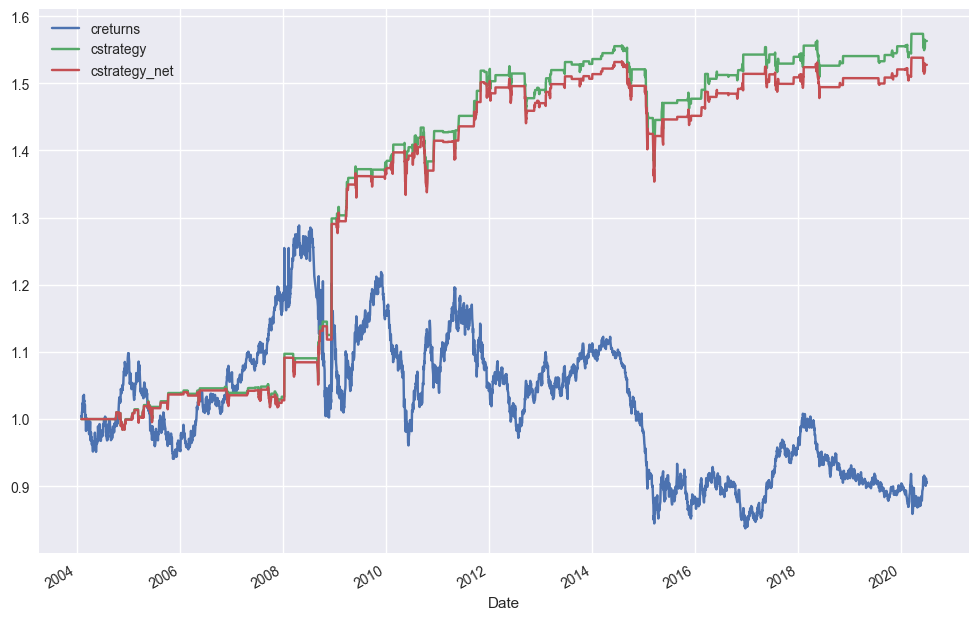

In [34]:
data[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

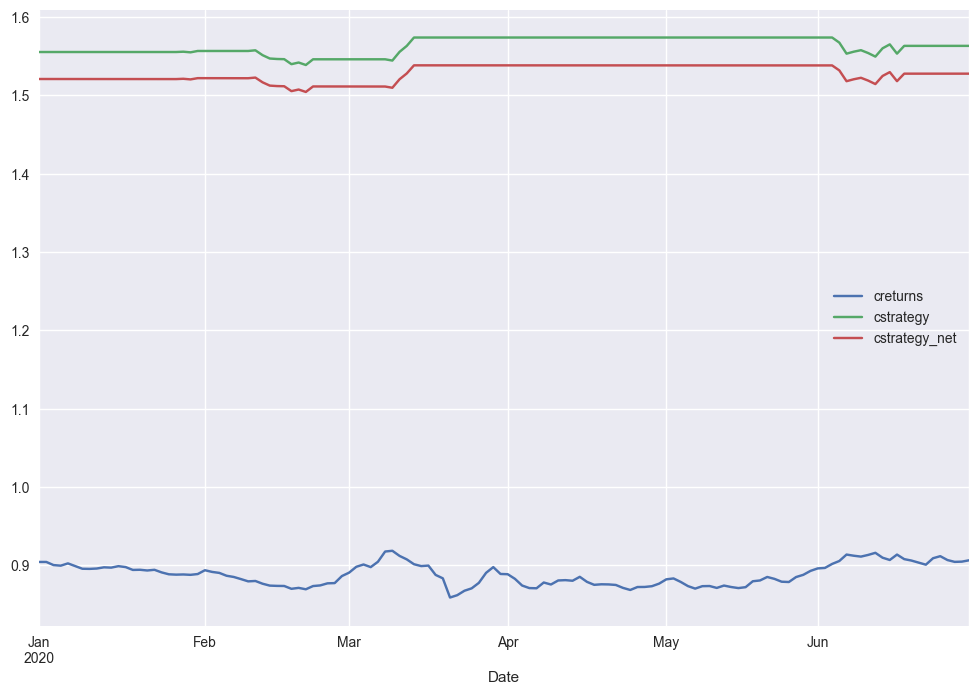

In [35]:
data.loc["2020", ["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

# Using the RSIBacktester Class

In [36]:
from RSIBacktester import RSIBacktester as RSI

In [37]:
ptc = 0.00007

In [38]:
tester = RSI("EURUSD=X", periods = 20, rsi_upper = 70, rsi_lower = 30,
              start = "2004-01-01", end = "2020-06-30", tc = ptc)

In [39]:
tester.test_strategy()

(np.float64(1.527501), np.float64(0.62353))

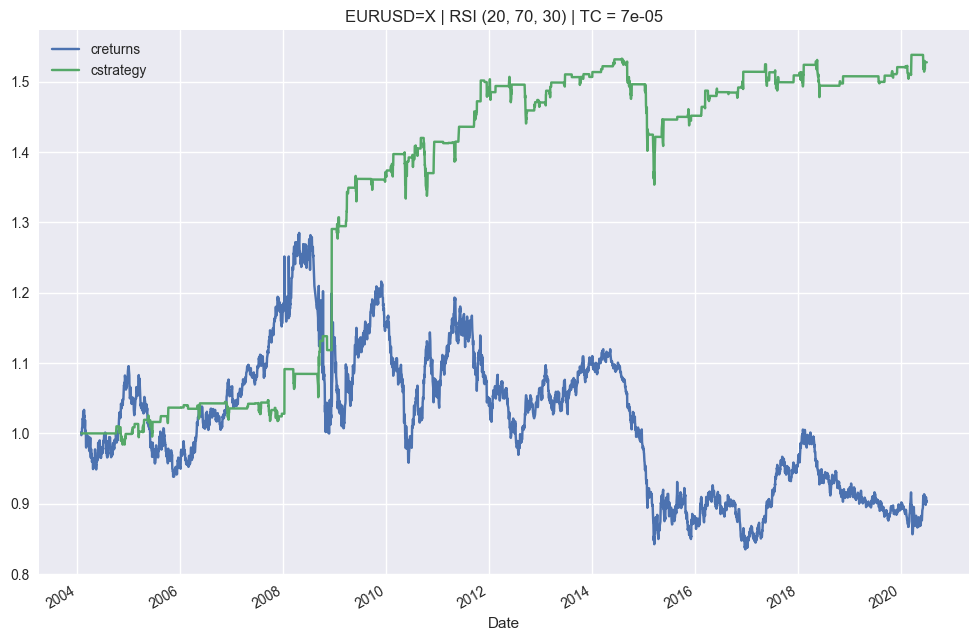

In [40]:
tester.plot_results()

In [41]:
tester.results

,price,returns,U,D,MA_U,MA_D,RSI,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,,
2004-01-29,1.241003,-0.002572,0.000000,0.003196,0.004610,0.005470,45.736150,0.0,-0.0,0.0,0.997431,1.000000
2004-01-30,1.246805,0.004665,0.005802,0.000000,0.004900,0.005470,47.254310,0.0,0.0,0.0,1.002095,1.000000
2004-02-02,1.243302,-0.002814,0.000000,0.003503,0.004375,0.005645,43.663573,0.0,-0.0,0.0,0.999279,1.000000
2004-02-03,1.253494,0.008164,0.010192,0.000000,0.004714,0.005645,45.509086,0.0,0.0,0.0,1.007471,1.000000
2004-02-04,1.253997,0.000401,0.000503,0.000000,0.004740,0.005244,47.471521,0.0,0.0,0.0,1.007875,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,0.003267,0.000000,0.003182,0.001530,67.538713,0.0,0.0,0.0,0.909207,1.527501
2020-06-25,1.125087,-0.005449,0.000000,0.006147,0.003007,0.001837,62.077668,0.0,-0.0,0.0,0.904266,1.527501
2020-06-26,1.122208,-0.002562,0.000000,0.002879,0.002696,0.001981,57.643190,0.0,-0.0,0.0,0.901953,1.527501


In [42]:
tester.optimize_parameters((5, 20, 1), (65, 80, 1), (20, 35, 1)) # higher volatility

(array([ 6., 65., 20.]), np.float64(2.582989))

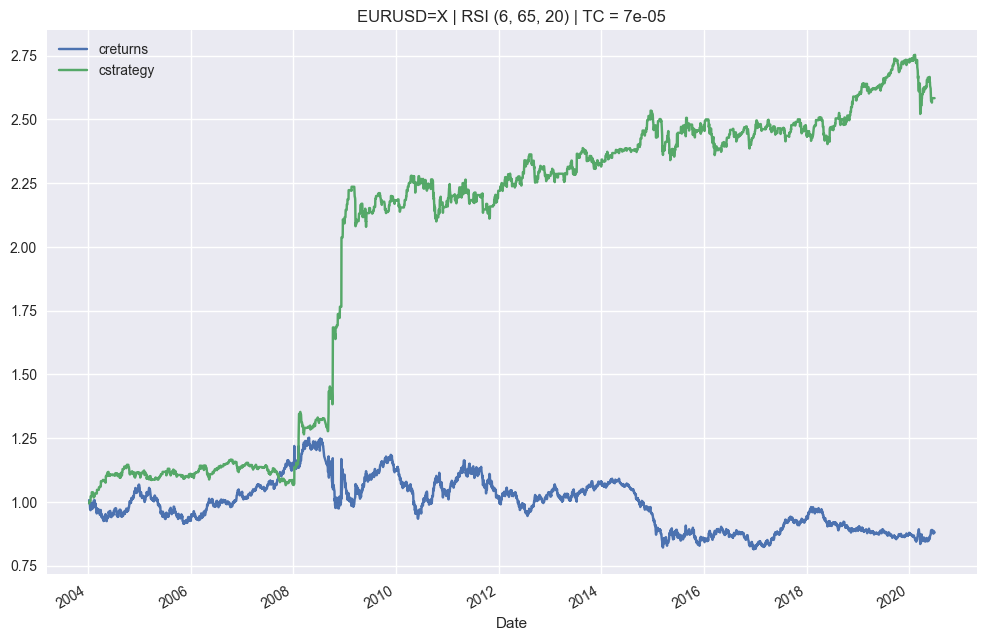

In [43]:
tester.plot_results()

In [44]:
tester.optimize_parameters((20, 50, 1), (75, 85, 1), (15, 25, 1)) # lower volatility

(array([26., 75., 24.]), np.float64(1.237744))

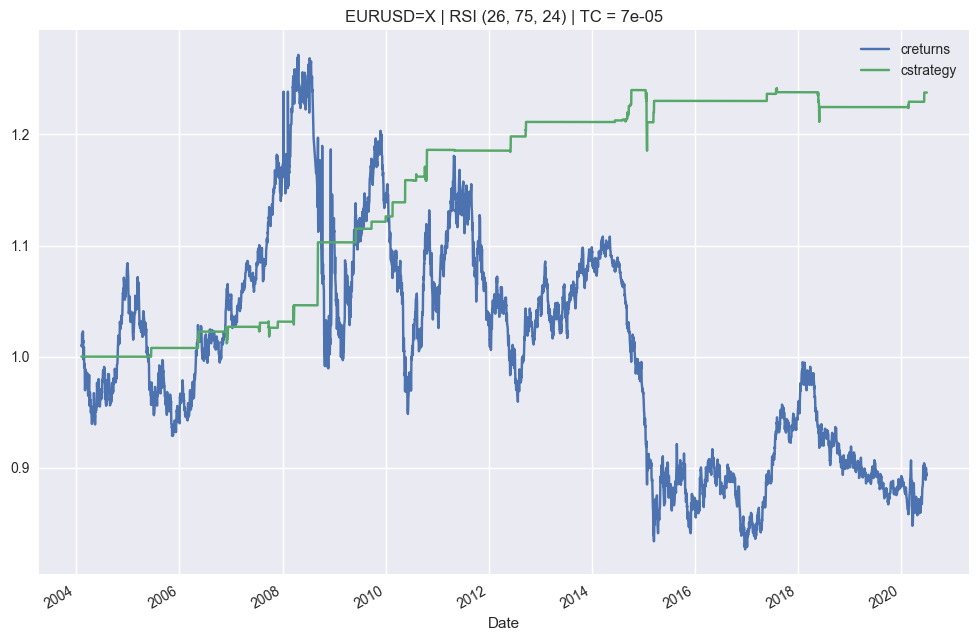

In [45]:
tester.plot_results()